# Preprocessing


=== MULAI SMART SCANNING ===
[INFO] Strategi 1 Gagal. Lanjut ke Strategi 2.
[ANALISIS ORIENTASI] Horizontal Votes: 28 | Vertical Votes: 0
[KEPUTUSAN] Gambar sudah Portrait. Melakukan Deskew halus: 8.05 derajat.


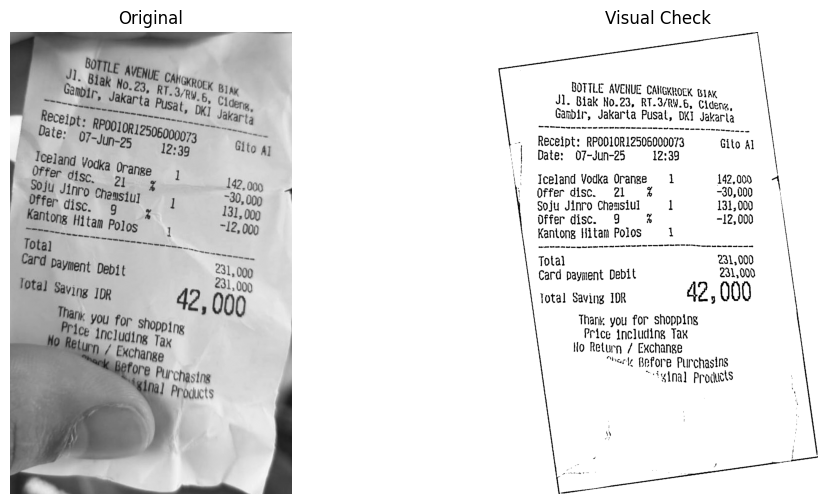

Using CPU. Note: This module is much faster with a GPU.



=== HASIL BACAAN OCR ===

--- TEXT AKHIR (Clean) ---
BottLE AVCHUC Cahgkrolk Biak
J] . Blak No.23, RT3/Rw.6; Cidena,
Ganblr , Jakarta Pusat , DKi Jakarta
RECEIPT RPOOZOR12506000073 Glto Al
Date: 07-Jun-25 12:39
Iceland Vodka Orange 1 142,000
OFFER dlsc. 21 8 -30,000
Soju Jinro Chamsiul 131,000
OFFER disc. 9 8 -12,000
Kantong Hitam Polos
TOTAL 231,000
Card PAYMENT DEBIT 231,000
TOTAL Savıng IDR 42,000
Tharik you for shopping
PRICE Including TAX
No Relurn 7 CHANGE
Cok Before Purchasins
Iglna] Procucts


In [30]:
import cv2
import numpy as np
import easyocr
from matplotlib import pyplot as plt
import os
import difflib
import re
import math

def order_points(pts):
    '''Mengurutkan 4 titik koordinat menjadi urutan kiri-atas, kanan-atas, kanan-bawah, kiri-bawah.'''
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    '''Melakukan transformasi perspektif geometri untuk mengubah sudut pandang miring menjadi tegak lurus.'''
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return warped

def auto_scan_document(image):
    '''Mendeteksi kontur terbesar yang memiliki 4 sudut untuk dianggap sebagai dokumen struk dan melakukan cropping otomatis.'''
    orig = image.copy()
    gray = cv2.GaussianBlur(image, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)

    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    screenCnt = None
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            break

    if screenCnt is not None:
        print("[INFO] Strategi 1: CamScanner Mode (4 Sudut Ditemukan)")
        pts = screenCnt.reshape(4, 2)
        warped = four_point_transform(orig, pts)
        return warped, True
    else:
        print("[INFO] Strategi 1 Gagal. Lanjut ke Strategi 2.")
        return image, False

def rotate_image(image, angle):
    '''Memutar gambar sebesar sudut tertentu tanpa memotong bagian gambar (memperluas canvas).'''
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    return cv2.warpAffine(image, M, (nW, nH), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

def detect_orientation_and_deskew(image):
    '''
    Fungsi cerdas untuk menentukan orientasi (Portrait/Landscape) dan meluruskan (Deskew) dalam satu langkah.
    Menggunakan analisis rasio aspek kontur teks untuk voting arah dominan.
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 10)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 3))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    horizontal_votes = 0
    vertical_votes = 0
    angles = []
    
    for c in contours:
        if cv2.contourArea(c) < 200:
            continue
            
        rect = cv2.minAreaRect(c)
        (center, (w, h), angle) = rect

        if w < h:
            w, h = h, w
            angle += 90
            
        aspect_ratio = w / float(h) if h > 0 else 0
        
        if aspect_ratio > 2.0:
            horizontal_votes += 1
            # Simpan sudut untuk deskewing nanti
            # Koreksi sudut agar range -45 sampai 45
            if angle > 45: angle -= 90
            elif angle < -45: angle += 90
            angles.append(angle)
            
        elif aspect_ratio < 0.5:
            vertical_votes += 1

    print(f"[ANALISIS ORIENTASI] Horizontal Votes: {horizontal_votes} | Vertical Votes: {vertical_votes}")
    
    if vertical_votes > horizontal_votes * 1.5:
        print("[KEPUTUSAN] Terdeteksi Teks Vertikal Dominan. Rotasi 90 Derajat.")
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
    else:
        if len(angles) > 0:
            median_angle = np.median(angles)
            print(f"[KEPUTUSAN] Gambar sudah Portrait. Melakukan Deskew halus: {median_angle:.2f} derajat.")
            
            if abs(median_angle) > 20:
                print("-> Sudut deskew terlalu besar, abaikan untuk keamanan.")
                return image
            elif abs(median_angle) < 0.5:
                print("-> Gambar sudah cukup lurus.")
                return image
            else:
                return rotate_image(image, median_angle)
        else:
            print("[KEPUTUSAN] Tidak cukup data sudut. Kembalikan gambar asli.")
            return image

def tuning_lab(image, blur_kernel=21, denoise_h=10, upscale=False):
    '''Mengatur alur pemrosesan: CamScanner -> Smart Orientation & Deskew -> Cleaning.'''
    if image is None: return None
    
    processed_img, success = auto_scan_document(image)
    
    processed_img = detect_orientation_and_deskew(processed_img)

    if upscale:
        processed_img = cv2.resize(processed_img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)

    visual_binary = cv2.adaptiveThreshold(
        processed_img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 15, 10
    )
    
    ocr_ready_img = cv2.fastNlMeansDenoising(processed_img, None, h=denoise_h, templateWindowSize=7, searchWindowSize=21)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(image, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(visual_binary, cmap='gray'); plt.title("Visual Check"); plt.axis('off')
    plt.show()
    
    return ocr_ready_img

def apply_spell_correction(text_line):
    '''Memperbaiki kesalahan ketik OCR pada kata kunci umum struk.'''
    RECEIPT_KEYWORDS = [
        "TOTAL", "SUBTOTAL", "CASH", "CHANGE", "PAYMENT", "DEBIT", "CREDIT",
        "TAX", "PAJAK", "PPN", "HARGA", "PRICE", "ITEM", "QTY", "AMOUNT",
        "RECEIPT", "STRUK", "KEMBALI", "TUNAI", "DISKON", "DISCOUNT", "OFFER",
        "SERVICE", "CHARGE", "GRAND"
    ]
    
    words = text_line.split()
    corrected_words = []
    
    for word in words:
        clean_word = ''.join(e for e in word if e.isalnum())
        if len(clean_word) < 3:
            corrected_words.append(word)
            continue
            
        matches = difflib.get_close_matches(clean_word.upper(), RECEIPT_KEYWORDS, n=1, cutoff=0.75)
        if matches:
            corrected_words.append(matches[0])
        else:
            corrected_words.append(word)
            
    return " ".join(corrected_words)

def cleanup_text_spacing(text):
    '''Membersihkan spasi berlebih pada angka.'''
    text = re.sub(r'(\d)\s*([.,])\s*(\d)', r'\1\2\3', text)
    text = re.sub(r'(@)\s+(\d)', r'\1\2', text)
    text = re.sub(r'(Rp)\s+(\d)', r'\1\2', text, flags=re.IGNORECASE)
    return text

def group_ocr_results(results, y_threshold=15):
    '''Mengelompokkan kata menjadi baris berdasarkan koordinat Y.'''
    def get_avg_y(box):
        return sum([p[1] for p in box]) / 4

    sorted_results = sorted(results, key=lambda x: get_avg_y(x[0]))
    lines = []
    current_line = []
    
    for i, (bbox, text, conf) in enumerate(sorted_results):
        current_y = get_avg_y(bbox)
        if not current_line:
            current_line.append((bbox, text))
            continue
        last_bbox = current_line[-1][0]
        last_y = get_avg_y(last_bbox)
        
        if abs(current_y - last_y) < y_threshold:
            current_line.append((bbox, text))
        else:
            lines.append(current_line)
            current_line = [(bbox, text)]
            
    if current_line: lines.append(current_line)
        
    final_text_lines = []
    for line in lines:
        line.sort(key=lambda x: x[0][0][0]) 
        combined_text = " ".join([item[1] for item in line])
        corrected_text = apply_spell_correction(combined_text)
        final_clean_text = cleanup_text_spacing(corrected_text)
        final_text_lines.append(final_clean_text)
        
    return "\n".join(final_text_lines)

img_path = "../../dataset/test/img/abel.jpg" 

if os.path.exists(img_path):
    original_img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    
    print("\n=== MULAI SMART SCANNING ===")
    result_image = tuning_lab(gray_img, blur_kernel=21, denoise_h=10, upscale=True)

    if result_image is not None:
        print("\n=== HASIL BACAAN OCR ===")
        reader = easyocr.Reader(['en', 'id'], gpu=False)
        raw_results = reader.readtext(result_image, detail=1) 
        
        final_clean_text = group_ocr_results(raw_results, y_threshold=20)
        
        print("\n--- TEXT AKHIR (Clean) ---")
        print(final_clean_text)
else:
    print(f"❌ Gambar tidak ditemukan di path: {img_path}")